## **DATA MINING IE 7275 PROJECT - GROUP 3**

### **Incident Management Analysis Using Event Log Data**

### **DATASET FROM UCI MACHINE LEARNING REPOSITORY**
#### https://archive.ics.uci.edu/dataset/498/incident+management+process+enriched+event+log

### **MILESTONE 1**

In [1]:
#importing necessary libraries
import pandas as pd

import numpy as np

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import seaborn as sns

from scipy.stats import chi2_contingency
import scipy.stats as stats

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import learning_curve

import xgboost as xgb

import plotly.graph_objects as go
import plotly.express as px

#### **DATA LOADING**

In [3]:
df = pd.read_csv('incident_event_log.csv')
print(df.info())  # Information about data types and null values
print(df.describe())  # Summary of data
print(df.head())  # Display the first few rows of data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141712 entries, 0 to 141711
Data columns (total 36 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   number                   141712 non-null  object
 1   incident_state           141712 non-null  object
 2   active                   141712 non-null  bool  
 3   reassignment_count       141712 non-null  int64 
 4   reopen_count             141712 non-null  int64 
 5   sys_mod_count            141712 non-null  int64 
 6   made_sla                 141712 non-null  bool  
 7   caller_id                141712 non-null  object
 8   opened_by                141712 non-null  object
 9   opened_at                141712 non-null  object
 10  sys_created_by           141712 non-null  object
 11  sys_created_at           141712 non-null  object
 12  sys_updated_by           141712 non-null  object
 13  sys_updated_at           141712 non-null  object
 14  contact_type        

#### **DATA PRE-PROCESSING**

In [5]:
# Convert timestamp columns to datetime format
datetime_cols = ['opened_at', 'sys_created_at', 'resolved_at', 'closed_at']
for col in datetime_cols:
    df[col] = pd.to_datetime(df[col], format="%d/%m/%Y %H:%M", errors='coerce', dayfirst=True)

# Drop irrelevant columns  and potential identifier columns
df.drop(columns=['problem_id', 'rfc', 'vendor',  'number', 'sys_id', 'caller_id', 'location'], inplace=True, errors='ignore')

# Drop unnecessary datetime columns (not useful for modeling)
df.drop(columns=datetime_cols, inplace=True)
df.info()

df.fillna({'cmdb_ci': 'Unknown', 'assigned_to': 'Unassigned'}, inplace=True)

print(df.info())
print(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141712 entries, 0 to 141711
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   incident_state           141712 non-null  object
 1   active                   141712 non-null  bool  
 2   reassignment_count       141712 non-null  int64 
 3   reopen_count             141712 non-null  int64 
 4   sys_mod_count            141712 non-null  int64 
 5   made_sla                 141712 non-null  bool  
 6   opened_by                141712 non-null  object
 7   sys_created_by           141712 non-null  object
 8   sys_updated_by           141712 non-null  object
 9   sys_updated_at           141712 non-null  object
 10  contact_type             141712 non-null  object
 11  category                 141712 non-null  object
 12  subcategory              141712 non-null  object
 13  u_symptom                141712 non-null  object
 14  cmdb_ci             

In [6]:
df['assigned_to'].replace('?', 'Unknown', inplace=True) #replacing ? with Unknown
print(df)

       incident_state  active  reassignment_count  reopen_count  \
0                 New    True                   0             0   
1            Resolved    True                   0             0   
2            Resolved    True                   0             0   
3              Closed   False                   0             0   
4                 New    True                   0             0   
...               ...     ...                 ...           ...   
141707         Closed   False                   1             0   
141708         Active    True                   0             0   
141709         Active    True                   1             0   
141710       Resolved    True                   1             0   
141711         Closed   False                   1             0   

        sys_mod_count  made_sla       opened_by  sys_created_by  \
0                   0      True    Opened by  8    Created by 6   
1                   2      True    Opened by  8    Created by

#### **DATA EXPLORATION**

**We'll perform the Chi-square test for independence to test if there is a significant relationship between two categorical variables.**

In [10]:
# Contingency table between 'incident_state' and 'priority'
contingency_table = pd.crosstab(df['incident_state'], df['priority'])

# Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f'Chi-Square Value: {chi2}')
print(f'P-Value: {p}')
print(f'Degrees of Freedom: {dof}')
print(f'Expected Frequencies: \n{expected}')

if p < 0.05:
    print("There is a significant relationship between 'incident_state' and 'priority'.")
else:
    print("There is no significant relationship between 'incident_state' and 'priority'.")

Chi-Square Value: 575.5056510304452
P-Value: 3.1294008889499818e-106
Degrees of Freedom: 24
Expected Frequencies: 
[[7.96686237e-02 1.04860562e-01 4.67328102e+00 1.42189793e-01]
 [6.16890087e+02 8.11956306e+02 3.61861496e+04 1.10100401e+03]
 [6.05481540e-01 7.96940273e-01 3.55169358e+01 1.08064243e+00]
 [7.34544710e+00 9.66814384e+00 4.30876510e+02 1.31098989e+01]
 [2.33301598e+02 3.07073671e+02 1.36852361e+04 4.16388591e+02]
 [1.12651434e+01 1.48272835e+01 6.60801936e+02 2.01056368e+01]
 [3.98104113e+02 5.23988230e+02 2.33523853e+04 7.10522398e+02]
 [5.80099117e+02 7.63531698e+02 3.40280284e+04 1.03534076e+03]
 [4.10309346e+02 5.40052868e+02 2.40683319e+04 7.32305874e+02]]
There is a significant relationship between 'incident_state' and 'priority'.


**We'll perform a Pearson correlation for numerical variables and analyze their relationships.**

                    sys_mod_count  reassignment_count  reopen_count
sys_mod_count            1.000000            0.527919      0.247292
reassignment_count       0.527919            1.000000      0.160193
reopen_count             0.247292            0.160193      1.000000


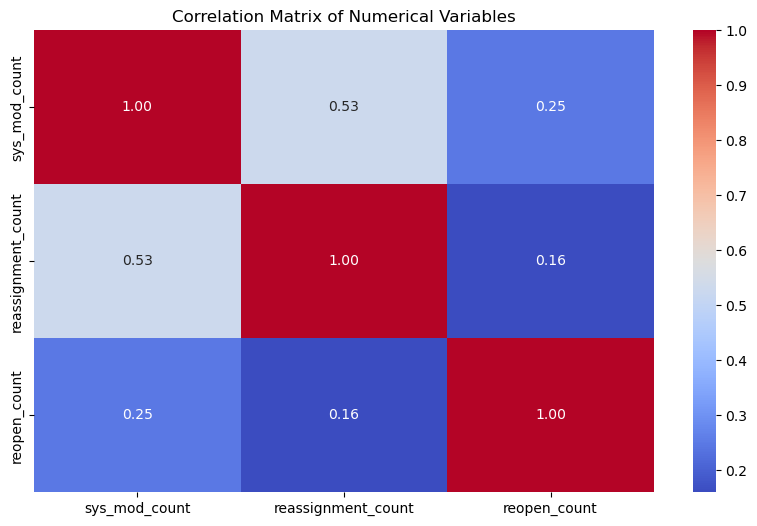

In [13]:
# Pearson correlation matrix
correlation_matrix = df[['sys_mod_count', 'reassignment_count', 'reopen_count']].corr()

# Correlation matrix
print(correlation_matrix)
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

The strongest relationship is between sys_mod_count and reassignment_count, but even this correlation is only moderate.

**The ANOVA test will help you understand if the numerical variables behave differently depending on the categories in your categorical variables (e.g., incident_state)**

In [20]:
# Example: ANOVA test for 'sys_mod_count' based on 'incident_state' (categorical variable)
anova_result = stats.f_oneway(
    *[df[df['incident_state'] == state]['sys_mod_count'].dropna() for state in df['incident_state'].unique()]
)

# Display the result of the ANOVA test
print(f"ANOVA test statistic: {anova_result.statistic}")
print(f"ANOVA test p-value: {anova_result.pvalue}")

# Interpretation
if anova_result.pvalue < 0.05:
    print("There is a statistically significant difference in the 'sys_mod_count' across the incident states.")
else:
    print("There is no statistically significant difference in the 'sys_mod_count' across the incident states.")

ANOVA test statistic: 2751.9593375862623
ANOVA test p-value: 0.0
There is a statistically significant difference in the 'sys_mod_count' across the incident states.


#### **DATA VISUALIZATION**

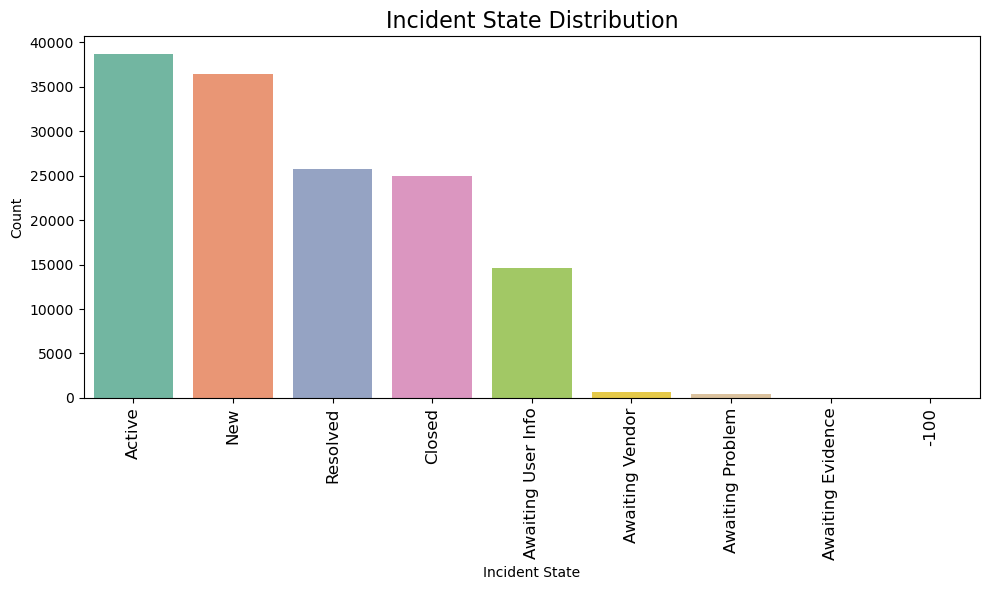

In [23]:
#Distribution of Incident States
valid_states = df['incident_state'].value_counts().index

# Plotting bar graph
plt.figure(figsize=(10, 6))
sns.countplot(x=df['incident_state'], palette="Set2", order=valid_states)
plt.title('Incident State Distribution', fontsize=16)
plt.xticks(rotation=90, fontsize=12)
plt.xlabel('Incident State')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [24]:
print(df['incident_state'].unique()) #listing all incident states

['New' 'Resolved' 'Closed' 'Active' 'Awaiting User Info'
 'Awaiting Problem' 'Awaiting Vendor' 'Awaiting Evidence' '-100']


['New' 'Resolved' 'Closed' 'Active' 'Awaiting User Info'
 'Awaiting Problem' 'Awaiting Vendor' 'Awaiting Evidence']


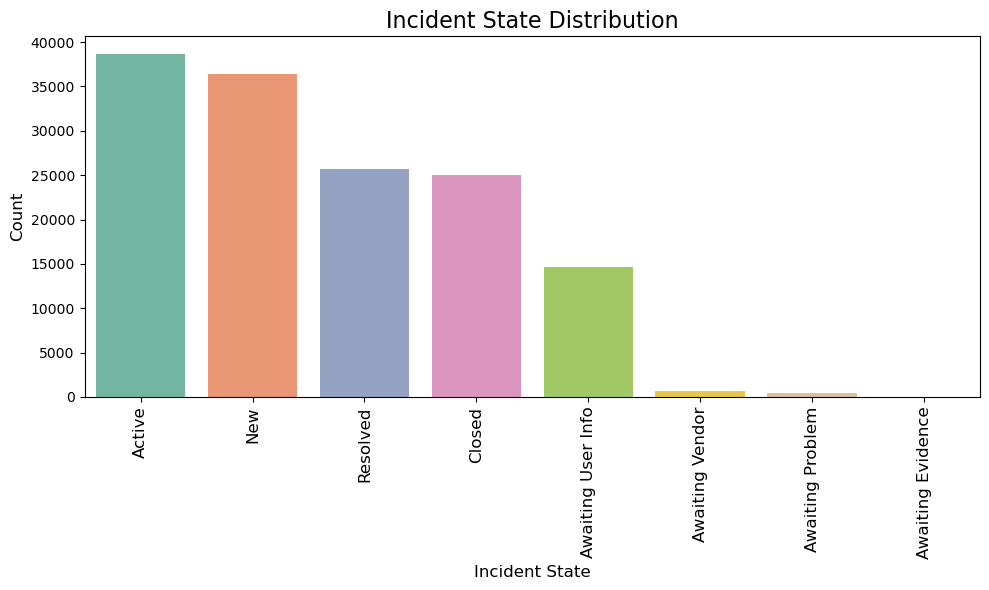

In [27]:
df['incident_state'] = df['incident_state'].astype(str)
df_filtered = df[df['incident_state'].str.match(r'^[A-Za-z\s]+$', na=False)]
print(df_filtered['incident_state'].unique())

#plotting the visual
plt.figure(figsize=(10, 6))
sns.countplot(x=df_filtered['incident_state'], palette="Set2", order=df_filtered['incident_state'].value_counts().index)
plt.title('Incident State Distribution', fontsize=16)
plt.xticks(rotation=90, fontsize=12)
plt.xlabel('Incident State', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()

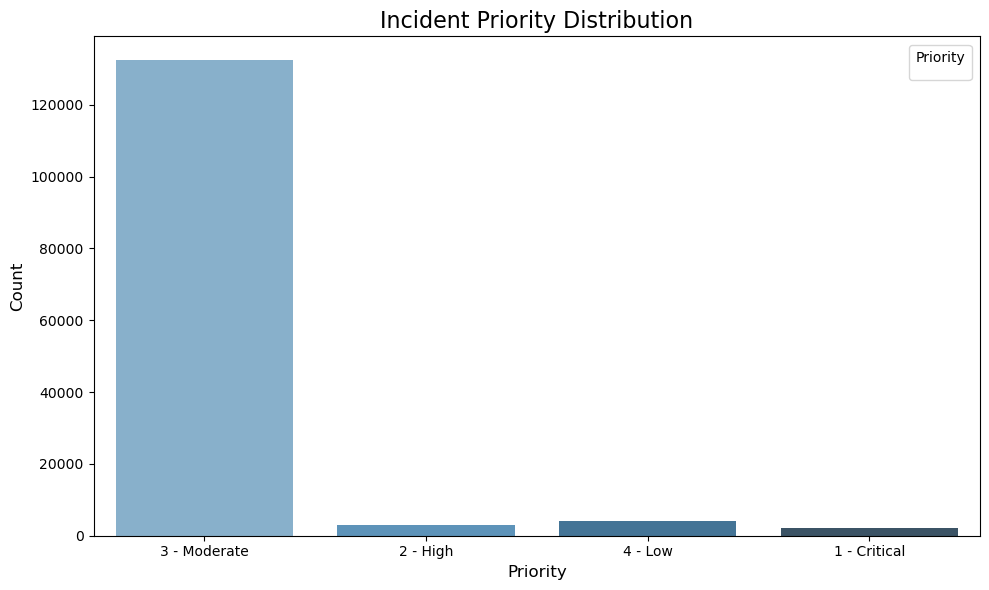

In [28]:
# Count of incidents based on priority
plt.figure(figsize=(10, 6))
sns.countplot(x='priority', data=df, hue='priority', dodge=False, palette='Blues_d')
plt.title('Incident Priority Distribution', fontsize=16)
plt.xlabel('Priority', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Priority', loc='upper right', fontsize=12)
plt.tight_layout()  # To prevent overlap
plt.show()

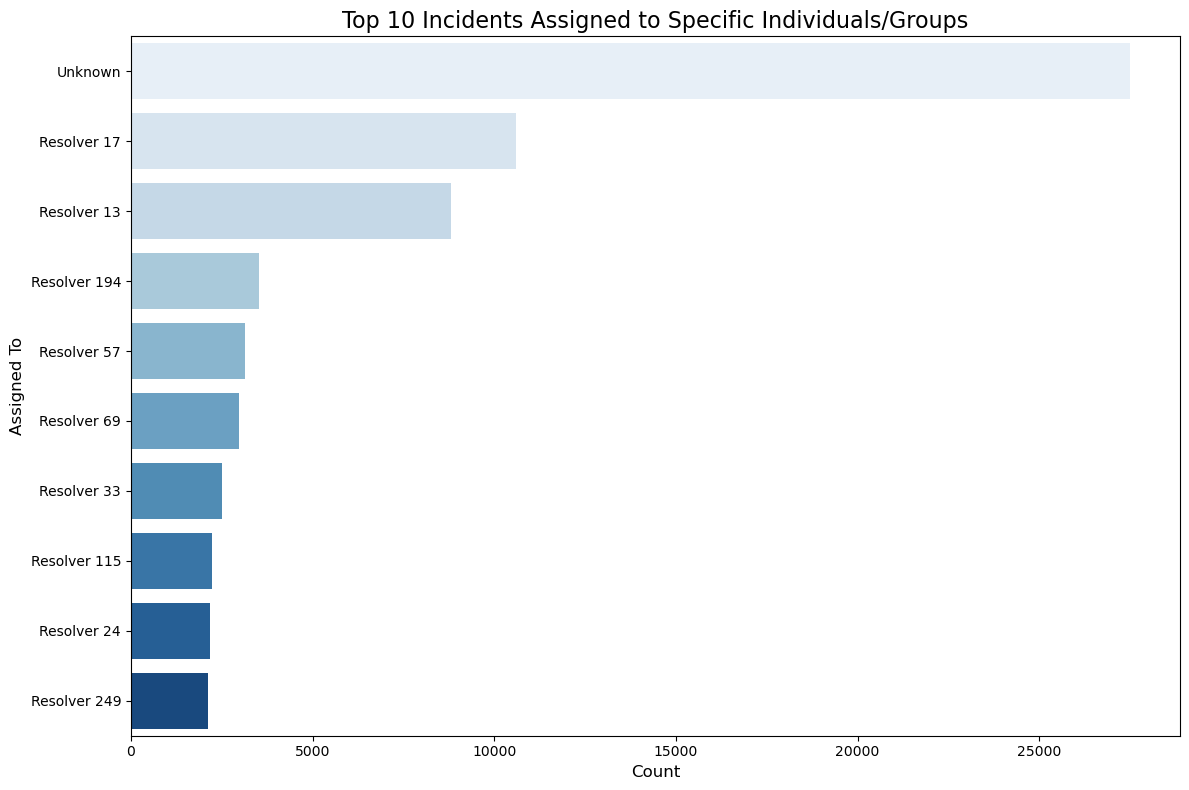

In [30]:
# Incident counts by assigned_to column
top_n = 10 #filtering top 10 since number of incidents is too high and the graph looks messy
plt.figure(figsize=(12, 8))

df_cleaned = df[df['assigned_to'].notna() & (df['assigned_to'] != '?')]# filtering unassigned incidents

sns.countplot(y='assigned_to', data=df_cleaned, order=df_cleaned['assigned_to'].value_counts().index[:top_n], palette="Blues")
plt.title(f'Top {top_n} Incidents Assigned to Specific Individuals/Groups', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Assigned To', fontsize=12)
plt.tight_layout()
plt.show()

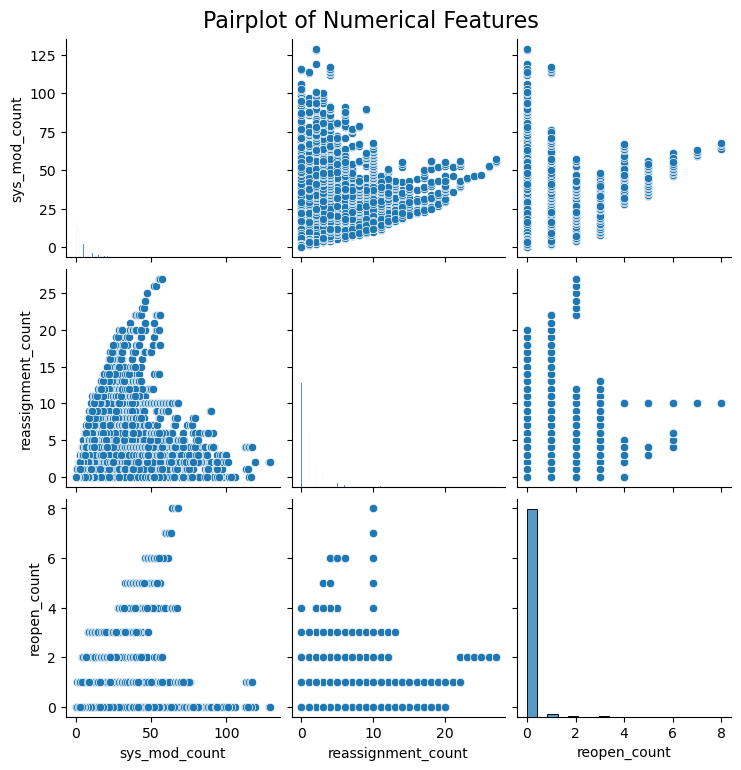

In [32]:
# Create a pairplot for a few numerical variables
sns.pairplot(df[['sys_mod_count', 'reassignment_count', 'reopen_count']])
plt.suptitle('Pairplot of Numerical Features', fontsize=16, y=1.02) 
plt.show()

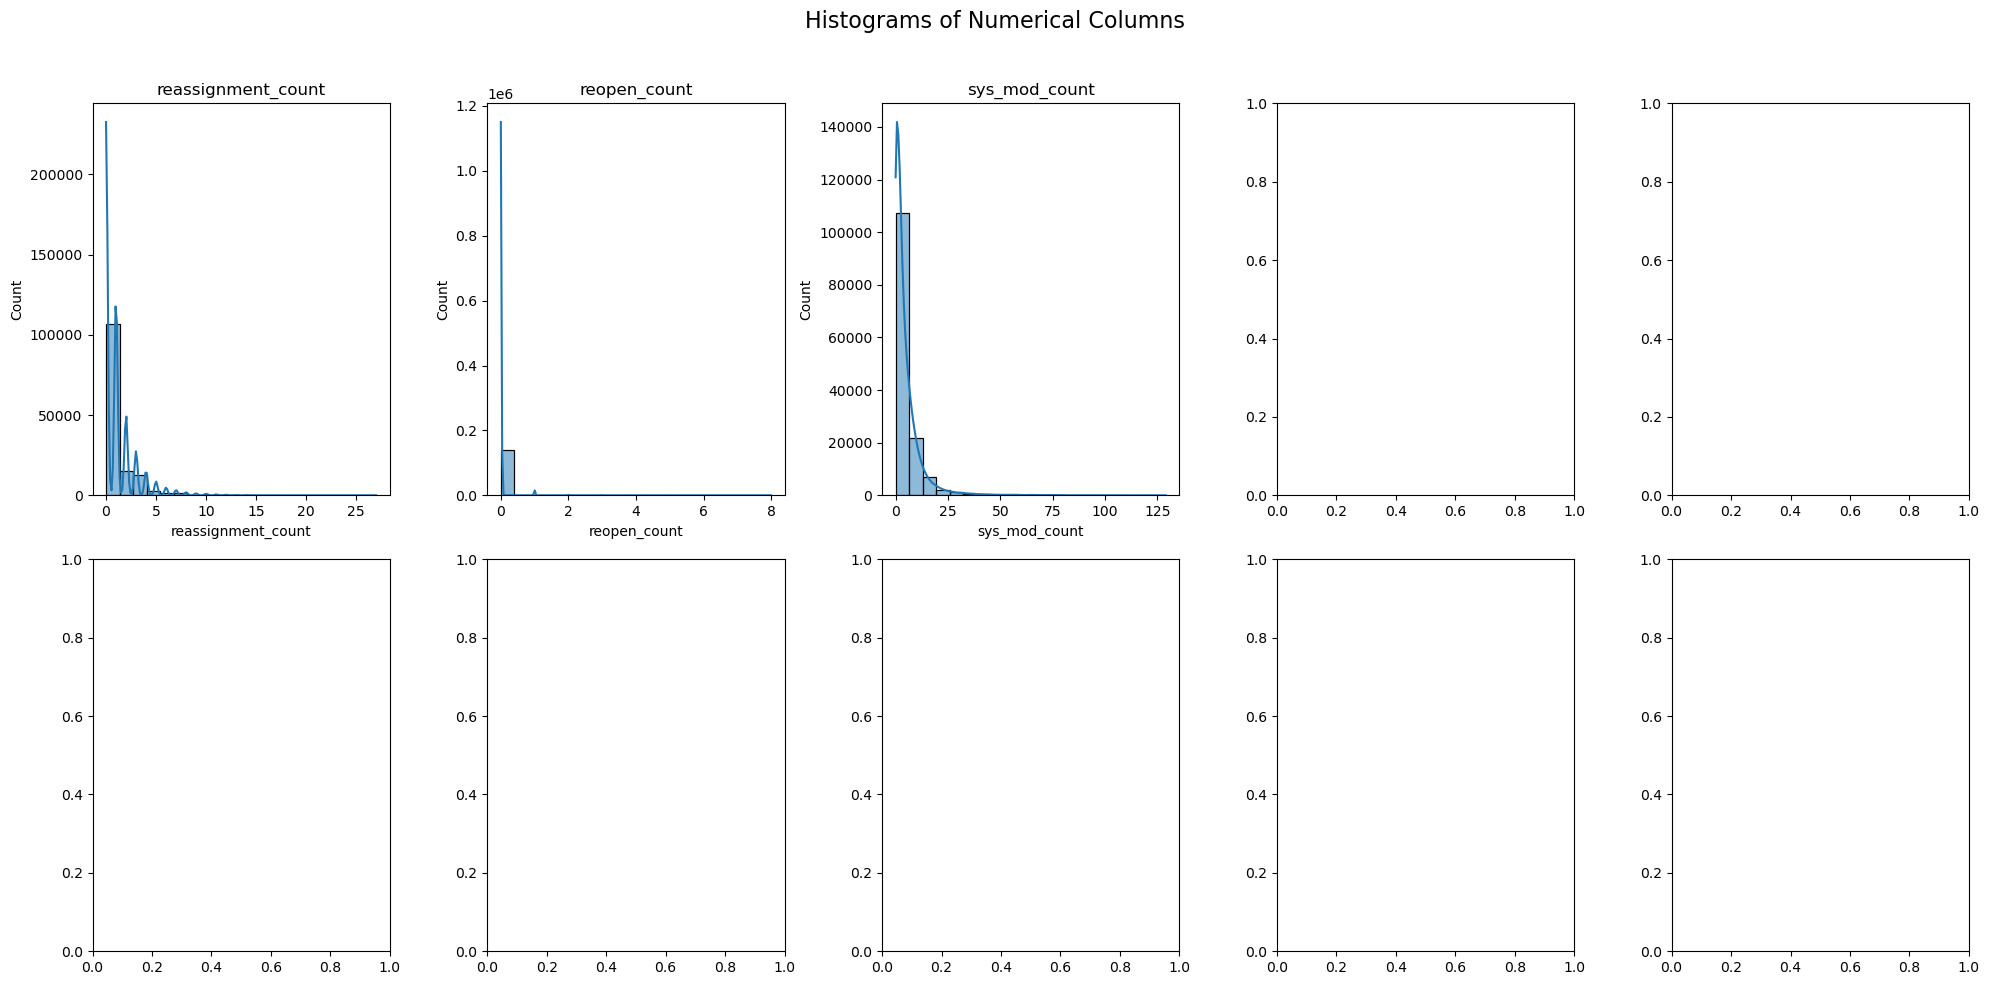

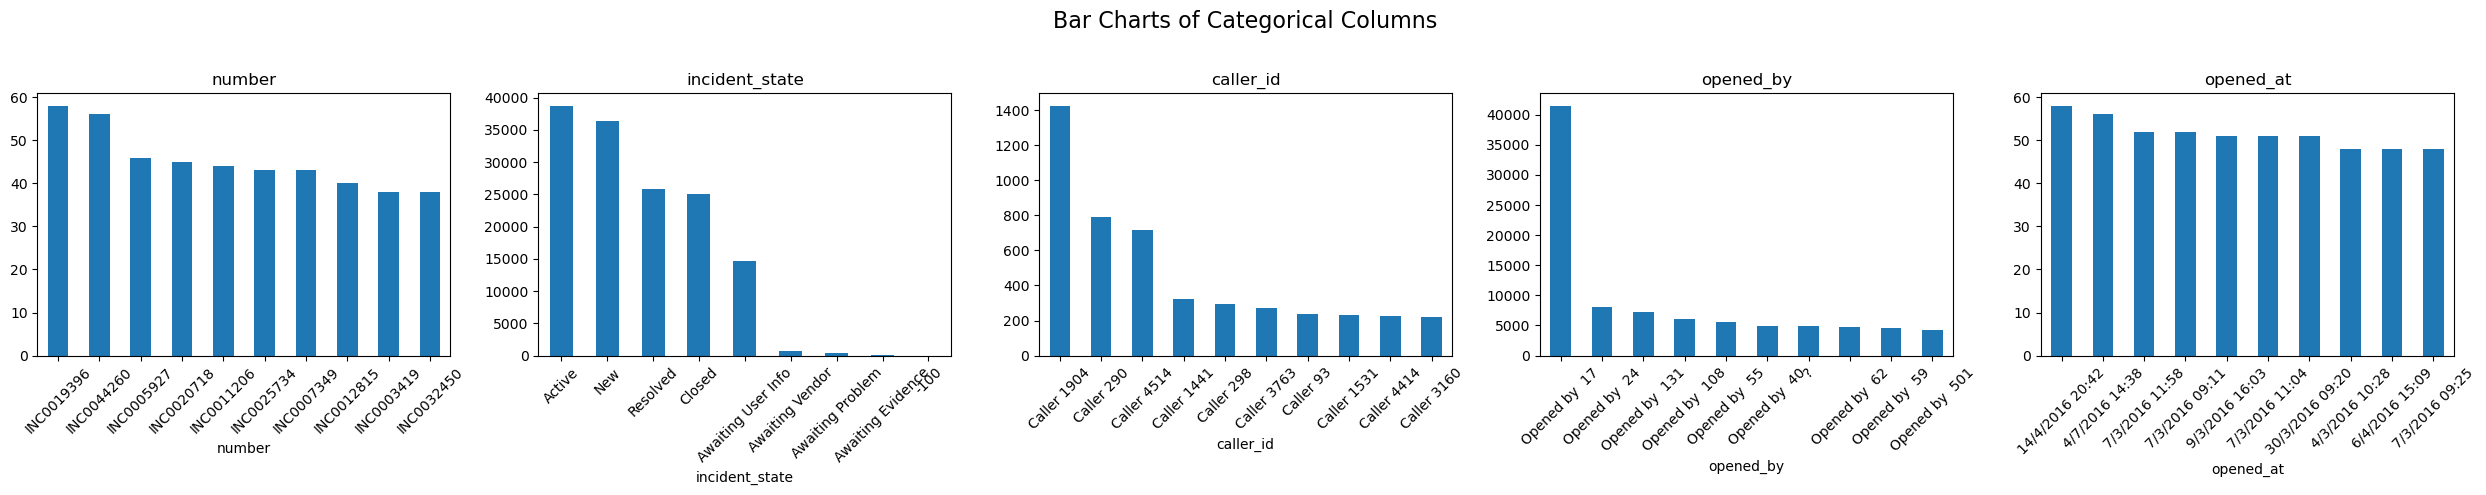

In [34]:
plt.close('all')
# Load the dataset
df = pd.read_csv('incident_event_log.csv')

# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()[:10]  # First 10 numerical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()[:5]  # First 5 categorical variables

# Set up figure for numerical histograms
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
fig.suptitle('Histograms of Numerical Columns', fontsize=16)

for i, col in enumerate(numerical_cols):
    ax = axes[i // 5, i % 5]
    sns.histplot(df[col].dropna(), kde=True, bins=20, ax=ax)
    ax.set_title(col)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Set up figure for categorical bar charts
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))
fig.suptitle('Bar Charts of Categorical Columns', fontsize=16)

for i, col in enumerate(categorical_cols):
    df[col].value_counts().nlargest(10).plot(kind='bar', ax=axes[i])
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [35]:
print(df.columns.tolist())

['number', 'incident_state', 'active', 'reassignment_count', 'reopen_count', 'sys_mod_count', 'made_sla', 'caller_id', 'opened_by', 'opened_at', 'sys_created_by', 'sys_created_at', 'sys_updated_by', 'sys_updated_at', 'contact_type', 'location', 'category', 'subcategory', 'u_symptom', 'cmdb_ci', 'impact', 'urgency', 'priority', 'assignment_group', 'assigned_to', 'knowledge', 'u_priority_confirmation', 'notify', 'problem_id', 'rfc', 'vendor', 'caused_by', 'closed_code', 'resolved_by', 'resolved_at', 'closed_at']


In [36]:
# Define relevant numeric columns
numeric_cols = [
    'reassignment_count',
    'reopen_count',
    'sys_mod_count',
    'active',
    'made_sla',
    'knowledge',
    'u_priority_confirmation'
]

# Convert boolean columns to integers
bool_cols = ['active', 'made_sla', 'knowledge', 'u_priority_confirmation']
df[bool_cols] = df[bool_cols].astype(int)

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[numeric_cols])

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Add the t-SNE results to the DataFrame
df['tsne_1'] = X_tsne[:, 0]
df['tsne_2'] = X_tsne[:, 1]

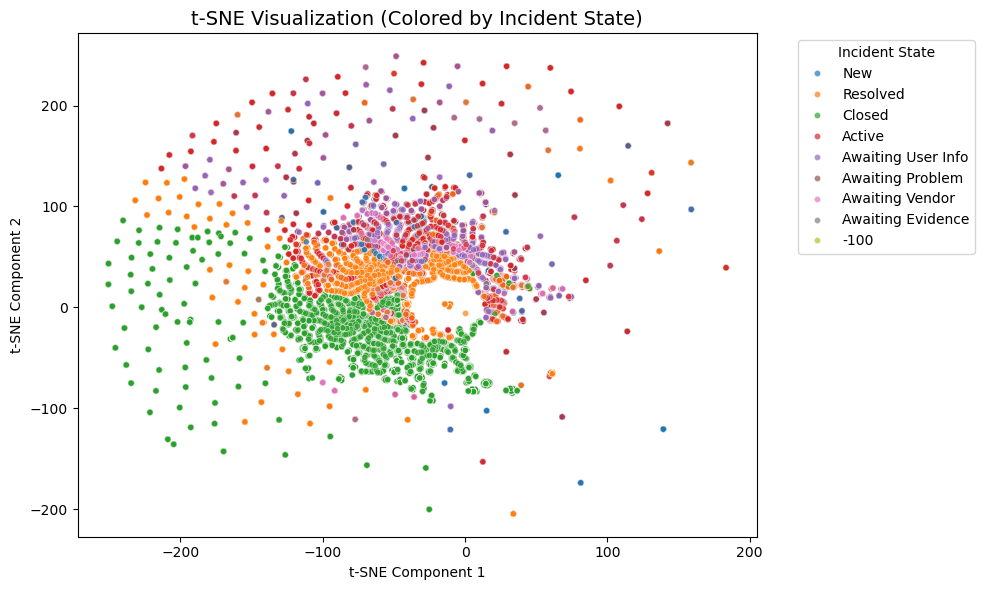

In [37]:
# Plot t-SNE result colored by incident_state
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='tsne_1',
    y='tsne_2',
    hue='incident_state',
    data=df,
    palette='tab10',
    s=20,
    alpha=0.7
)
plt.title('t-SNE Visualization (Colored by Incident State)', fontsize=14)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Incident State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("tsne_visualization.png", dpi=300)  
plt.show()

The visualization aids in understanding how different incident states relate spatially, possibly reflecting the urgency or the progression in resolution status.
Clusters signify similar characteristics or features of incidents, useful for resource allocation and management strategies

### **MILESTONE 2**

In [40]:
#update from milestone 1
cat_cols = ['incident_state', 'priority', 'assigned_to', 'category', 'impact']
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Convert to datetime
df['opened_at'] = pd.to_datetime(df['opened_at'], errors='coerce')
df['resolved_at'] = pd.to_datetime(df['resolved_at'], errors='coerce')

# Now calculate resolution time in seconds
df['resolution_time'] = (df['resolved_at'] - df['opened_at']).dt.total_seconds()

# Drop rows where conversion failed or dates were missing
df = df.dropna(subset=['resolution_time'])
# Drop identifier columns that do not help with predictions
drop_cols = ['number', 'caller_id', 'opened_by', 'sys_created_by', 'sys_updated_by', 'resolved_by']
df = df.drop(columns=drop_cols, errors='ignore')

# Convert 'sys_updated_at' to datetime and extract meaningful features
df['sys_updated_at'] = pd.to_datetime(df['sys_updated_at'], errors='coerce')
df['sys_updated_hour'] = df['sys_updated_at'].dt.hour
df['sys_updated_weekday'] = df['sys_updated_at'].dt.weekday
df['sys_updated_month'] = df['sys_updated_at'].dt.month
df.drop(columns=['sys_updated_at'], inplace=True)  # Remove original datetime column

# Convert categorical variables to numeric using Label Encoding
cat_cols = ['incident_state', 'contact_type', 'location', 'category', 'subcategory',
            'u_symptom', 'cmdb_ci', 'impact', 'urgency', 'priority', 
            'assignment_group', 'notify', 'closed_code']

In [41]:
# Define feature set (X) and target variable (y)
X = df.drop(columns=['resolution_time'])  # Features
y = df['resolution_time']  # Target variable

# Split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
# Select only numeric columns
numeric_cols = X_train.select_dtypes(include=[np.number]).columns
X_train_numeric = X_train[numeric_cols]
X_test_numeric = X_test[numeric_cols]

# Apply StandardScaler only on numeric data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_test_scaled = scaler.transform(X_test_numeric)

# Convert the scaled data back to DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=numeric_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=numeric_cols, index=X_test.index)

In [44]:
# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Neural Network": MLPRegressor(hidden_layer_sizes=(50,50), max_iter=1000, random_state=42)
}

# Train each model
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    print(f"{name} trained successfully.")

Linear Regression trained successfully.
Decision Tree trained successfully.
Random Forest trained successfully.
Gradient Boosting trained successfully.
Neural Network trained successfully.


In [77]:
metrics = {}
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)

    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    metrics[name] = {"R² Score": r2, "MAE": mae, "MSE": mse, "RMSE": rmse, "MAPE": mape}

In [79]:
metrics_df = pd.DataFrame(metrics).T
print(metrics_df)

best_model = metrics_df['R² Score'].idxmax()
print(f"🏆 Best Model: {best_model} with R² Score of {metrics_df.loc[best_model, 'R² Score']:.3f}")

                   R² Score            MAE           MSE          RMSE  MAPE
Linear Regression  0.460081  792017.472051  3.111450e+12  1.763930e+06   inf
Decision Tree      0.380079  650117.072426  3.572487e+12  1.890102e+06   inf
Random Forest      0.649387  559150.976416  2.020517e+12  1.421449e+06   inf
Gradient Boosting  0.550579  676011.582363  2.589929e+12  1.609326e+06   inf
Neural Network     0.518321  687348.977500  2.775827e+12  1.666081e+06   inf
🏆 Best Model: Random Forest with R² Score of 0.649


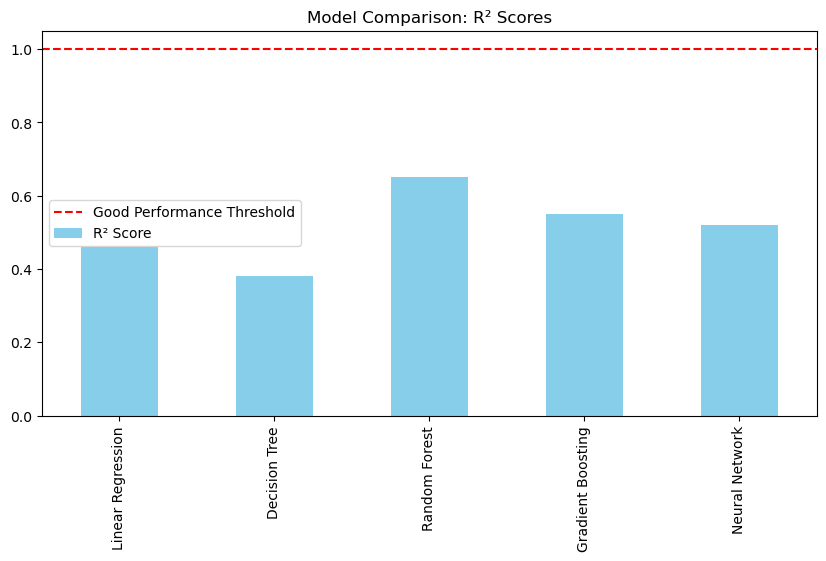

In [81]:
plt.figure(figsize=(10,5))
metrics_df['R² Score'].plot(kind='bar', color='skyblue')
plt.title("Model Comparison: R² Scores")
plt.axhline(y=1, color='red', linestyle='--', label='Good Performance Threshold')
plt.legend()
plt.show()

Insights for Mean Absolute Error (MAE):
- Model with the lowest MAE: Random Forest (559150.9764)
- Model with the highest MAE: Linear Regression (792017.4721)
  Lower MAE values indicate better prediction accuracy. A lower MAE suggests the model makes more consistent predictions with smaller average errors.

Insights for Mean Squared Error (MSE):
- Model with the lowest MSE: Random Forest (2020517027943.6023)
- Model with the highest MSE: Decision Tree (3572487285655.9229)
  Lower MSE values indicate better model performance, as MSE penalizes larger errors more. A lower MSE suggests the model is better at minimizing large prediction errors.

Insights for Root Mean Squared Error (RMSE):
- Model with the lowest RMSE: Random Forest (1421448.9185)
- Model with the highest RMSE: Decision Tree (1890102.4537)
  RMSE maintains the same units as the target variable. A lower RMSE indicates better overall prediction accuracy.

Insights for R² Score:
- Model with the highest R² Score: Random Fores

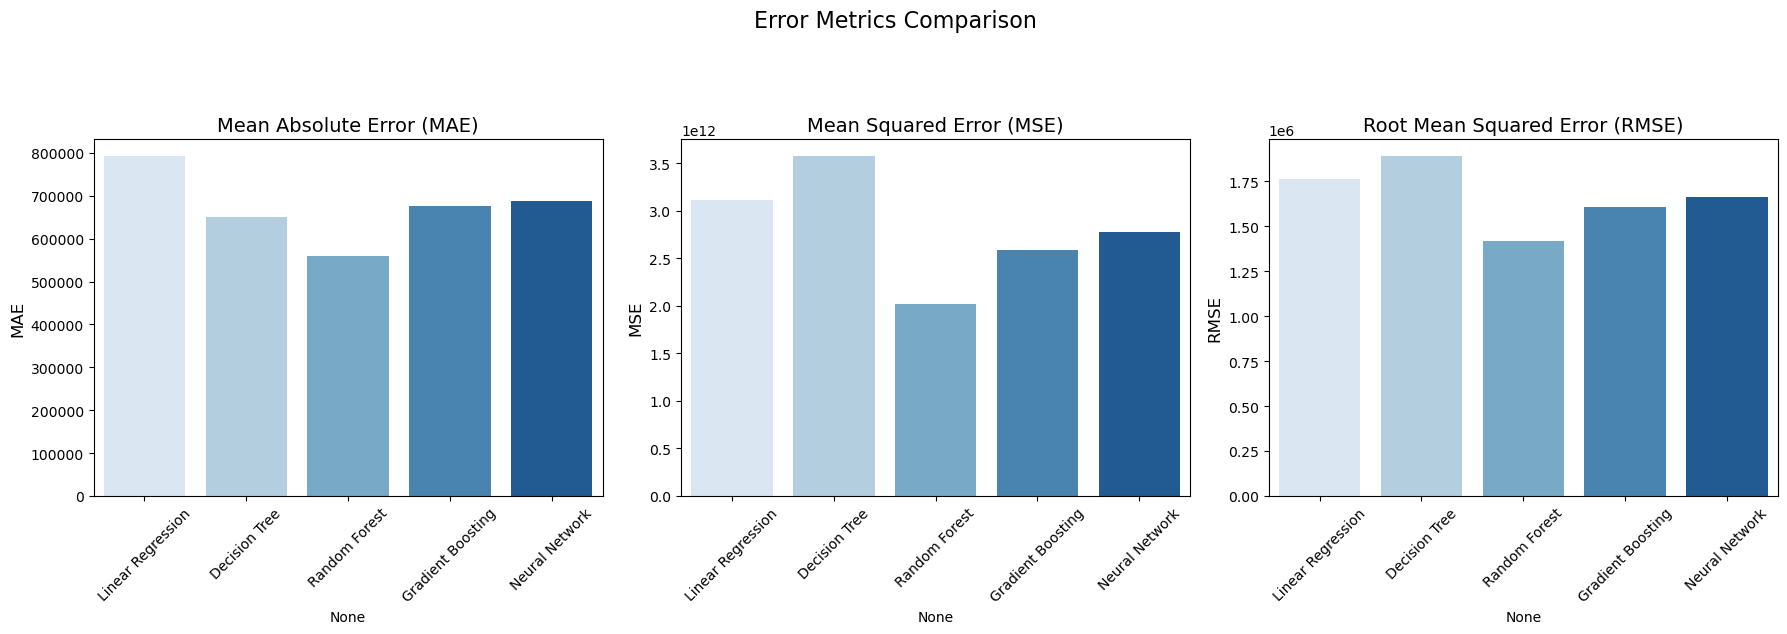

In [83]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Error Metrics Comparison", fontsize=16, y=1.05)

# Plot for Mean Absolute Error (MAE)
sns.barplot(x=metrics_df.index, y=metrics_df["MAE"], palette="Blues", ax=axes[0])
axes[0].set_title("Mean Absolute Error (MAE)", fontsize=14)
axes[0].set_ylabel("MAE", fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Insights for MAE
mae_best_model = metrics_df["MAE"].idxmin()
mae_worst_model = metrics_df["MAE"].idxmax()
print("Insights for Mean Absolute Error (MAE):")
print(f"- Model with the lowest MAE: {mae_best_model} ({metrics_df.loc[mae_best_model, 'MAE']:.4f})")
print(f"- Model with the highest MAE: {mae_worst_model} ({metrics_df.loc[mae_worst_model, 'MAE']:.4f})")
print("  Lower MAE values indicate better prediction accuracy. A lower MAE suggests the model makes more consistent predictions with smaller average errors.\n")

# Plot for Mean Squared Error (MSE)
sns.barplot(x=metrics_df.index, y=metrics_df["MSE"], palette="Blues", ax=axes[1])
axes[1].set_title("Mean Squared Error (MSE)", fontsize=14)
axes[1].set_ylabel("MSE", fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

# Insights for MSE
mse_best_model = metrics_df["MSE"].idxmin()
mse_worst_model = metrics_df["MSE"].idxmax()
print("Insights for Mean Squared Error (MSE):")
print(f"- Model with the lowest MSE: {mse_best_model} ({metrics_df.loc[mse_best_model, 'MSE']:.4f})")
print(f"- Model with the highest MSE: {mse_worst_model} ({metrics_df.loc[mse_worst_model, 'MSE']:.4f})")
print("  Lower MSE values indicate better model performance, as MSE penalizes larger errors more. A lower MSE suggests the model is better at minimizing large prediction errors.\n")

# Plot for Root Mean Squared Error (RMSE)
sns.barplot(x=metrics_df.index, y=metrics_df["RMSE"], palette="Blues", ax=axes[2])
axes[2].set_title("Root Mean Squared Error (RMSE)", fontsize=14)
axes[2].set_ylabel("RMSE", fontsize=12)
axes[2].tick_params(axis='x', rotation=45)

# Insights for RMSE
rmse_best_model = metrics_df["RMSE"].idxmin()
rmse_worst_model = metrics_df["RMSE"].idxmax()
print("Insights for Root Mean Squared Error (RMSE):")
print(f"- Model with the lowest RMSE: {rmse_best_model} ({metrics_df.loc[rmse_best_model, 'RMSE']:.4f})")
print(f"- Model with the highest RMSE: {rmse_worst_model} ({metrics_df.loc[rmse_worst_model, 'RMSE']:.4f})")
print("  RMSE maintains the same units as the target variable. A lower RMSE indicates better overall prediction accuracy.\n")

# Additional insights for R² Score
r2_best_model = metrics_df["R² Score"].idxmax()
r2_worst_model = metrics_df["R² Score"].idxmin()
print("Insights for R² Score:")
print(f"- Model with the highest R² Score: {r2_best_model} ({metrics_df.loc[r2_best_model, 'R² Score']:.4f})")
print(f"- Model with the lowest R² Score: {r2_worst_model} ({metrics_df.loc[r2_worst_model, 'R² Score']:.4f})")
print("  R² Score indicates how well the model explains variance in the data. A higher R² Score (closer to 1) means a better fit.\n")

# Additional insights for MAPE
mape_best_model = metrics_df["MAPE"].idxmin()
mape_worst_model = metrics_df["MAPE"].idxmax()
print("Insights for Mean Absolute Percentage Error (MAPE):")
print(f"- Model with the lowest MAPE: {mape_best_model} ({metrics_df.loc[mape_best_model, 'MAPE']:.2f}%)")
print(f"- Model with the highest MAPE: {mape_worst_model} ({metrics_df.loc[mape_worst_model, 'MAPE']:.2f}%)")
print("  MAPE represents the average percentage error. A lower MAPE suggests better predictive performance.\n")

# Adjust layout to avoid overlapping
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


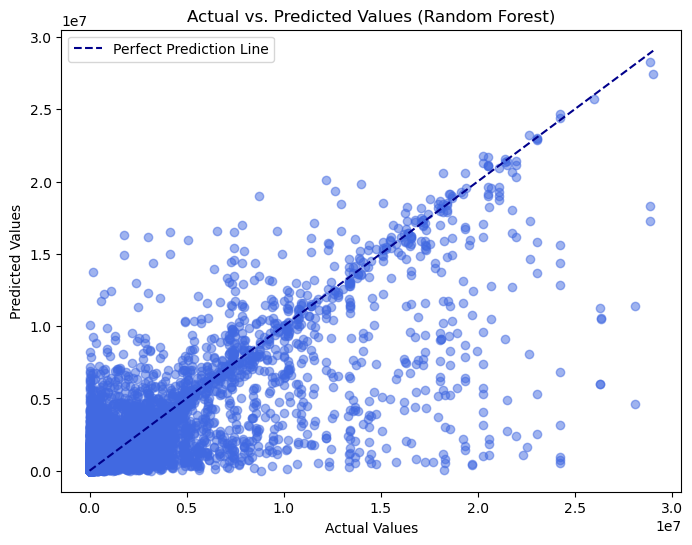

In [85]:
best_model_name = metrics_df["R² Score"].idxmax() # Best model based on R² Score
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test_scaled)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_best, alpha=0.5, color="royalblue")  # Blue scatter points
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="--", color="darkblue", label="Perfect Prediction Line")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs. Predicted Values ({best_model_name})")
plt.legend()
plt.show()

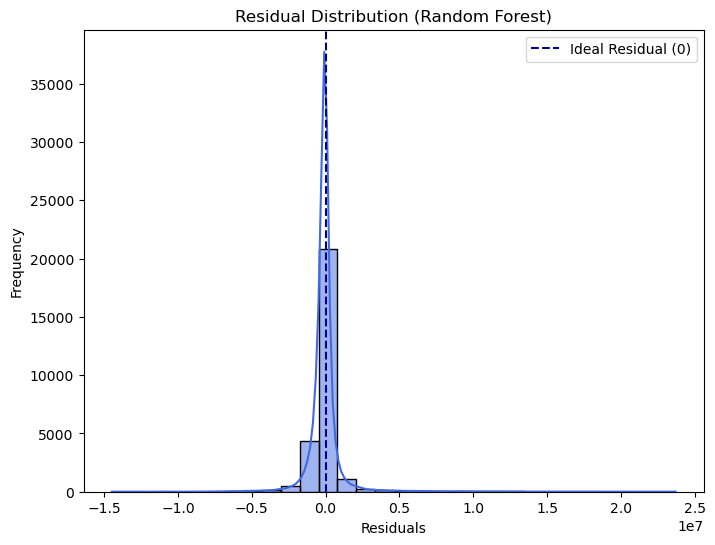

In [87]:
plt.figure(figsize=(8, 6))
residuals = y_test - y_pred_best # Errors
sns.histplot(residuals, bins=30, kde=True, color="royalblue")
plt.axvline(x=0, color="darkblue", linestyle="--", label="Ideal Residual (0)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title(f"Residual Distribution ({best_model_name})")
plt.legend()
plt.show()

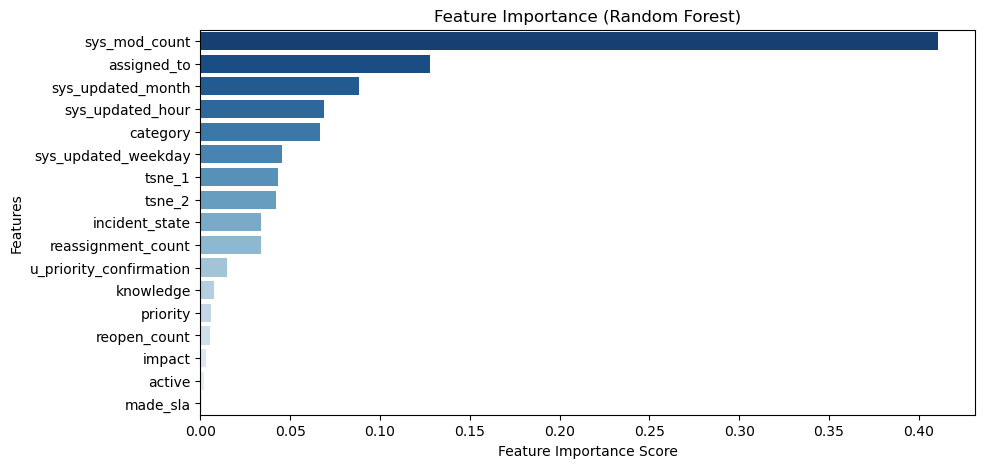

In [89]:
if hasattr(best_model, "feature_importances_"): # Works for trees
    importance_df = pd.DataFrame({"Feature": X_train_numeric.columns, "Importance": best_model.feature_importances_})
    importance_df = importance_df.sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=importance_df["Importance"], y=importance_df["Feature"], palette="Blues_r")
    plt.xlabel("Feature Importance Score")
    plt.ylabel("Features")
    plt.title(f"Feature Importance ({best_model_name})")
    plt.show()

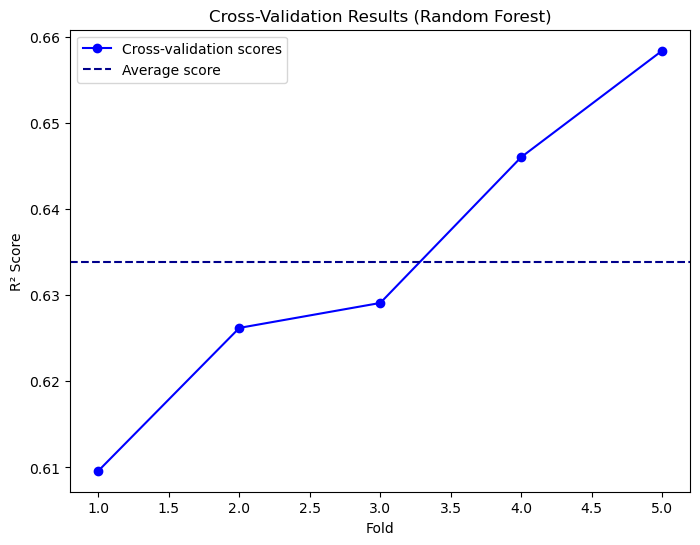

In [91]:
# Perform cross-validation for the best model
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring="r2")

# Plot the cross-validation results
plt.figure(figsize=(8, 6))
plt.plot(range(1, 6), cv_scores, marker='o', color="blue", label="Cross-validation scores")
plt.axhline(y=cv_scores.mean(), color="darkblue", linestyle="--", label="Average score")
plt.xlabel("Fold")
plt.ylabel("R² Score")
plt.title(f"Cross-Validation Results ({best_model_name})")
plt.legend()
plt.show()

In [92]:
# Insights
print("Cross-Validation R² Scores:", cv_scores)
print("Average R² Score:", cv_scores.mean())
print("Standard Deviation of R² Scores:", cv_scores.std())

# Final Insights
if cv_scores.mean() > 0.6:
    print("The model performs decently, but there may be room for improvement.")
else:
    print("The model performance could be improved. We can consider tuning hyperparameters or using a different model.")

Cross-Validation R² Scores: [0.60962244 0.62621129 0.62910936 0.64604265 0.65840482]
Average R² Score: 0.6338781107624271
Standard Deviation of R² Scores: 0.016848705767713464
The model performs decently, but there may be room for improvement.
